In [3]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [4]:
!pip install wordcloud


In [5]:
from wordcloud import WordCloud

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv("C:/Users/Kashvi Varma/Desktop/NMIMS/7_sem/SNLP/spam.csv", encoding='latin-1')

# Rename columns for easier access
df = df.rename(columns={"v1": "label", "v2": "text"})

# Keep only the necessary columns
df = df[['label', 'text']]


[nltk_data] Downloading package stopwords to C:\Users\Kashvi
[nltk_data]     Varma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Kashvi
[nltk_data]     Varma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kashvi
[nltk_data]     Varma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
df.head(20)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\b\w+@\w+\.\w+\b', '', text)  # Remove email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\<.*?\>', '', text)  # Remove HTML tags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)



In [9]:
df['processed_text']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5567    nd time tried contact u u å£ pound prize claim...
5568                          ì b going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: processed_text, Length: 5572, dtype: object

# 1.a ) Function to get top words

In [10]:
stop_words = set(stopwords.words('english'))

def get_top_words(text_series, top_n=10):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_series)
    feature_names = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    word_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return sorted_word_freq[:top_n]

# Example usage
top_words = get_top_words(df['processed_text'])

# Convert to DataFrame
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Save to CSV file
top_words_df.to_csv('top_words.csv', index=False)

# Optionally print the DataFrame
print(top_words_df)

   Word  Frequency
0    im        464
1    ur        384
2  dont        279
3  free        278
4    ok        277
5  ltgt        276
6  know        257
7   got        251
8  like        242
9   ill        237


# 1. b&c) Function to get top n-grams


In [11]:
def get_top_ngrams(text_series, ngram_range=(1, 1), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(text_series)
    feature_names = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    ngram_freq = [(ngram, sums[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    sorted_ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return sorted_ngram_freq[:top_n]

# Extracting bigrams and trigrams
top_bigrams = get_top_ngrams(df['processed_text'], ngram_range=(2, 2))
top_trigrams = get_top_ngrams(df['processed_text'], ngram_range=(3, 3))

# Convert to DataFrames
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
top_trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])

# Print the DataFrames
print("Top 10 Bigrams:")
print(top_bigrams_df)

print("\nTop 10 Trigrams:")
print(top_trigrams_df)

Top 10 Bigrams:
         Bigram  Frequency
0        gon na         58
1     ill later         43
2      let know         40
3     sorry ill         39
4     dont know         38
5        wan na         38
6  good morning         30
7        po box         29
8      im going         24
9      new year         23

Top 10 Trigrams:
                      Trigram  Frequency
0             sorry ill later         38
1                   im gon na         20
2              happy new year         18
3   private account statement         16
4       prize guaranteed land         15
5        guaranteed land line         15
6            draw shows prize         14
7      shows prize guaranteed         14
8     account statement shows         14
9  statement shows unredeemed         14


# 1. d)  Define stopwords set and make word cloud


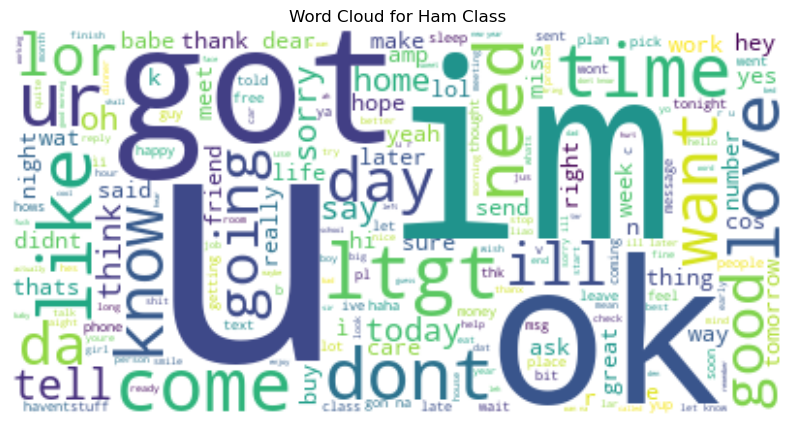

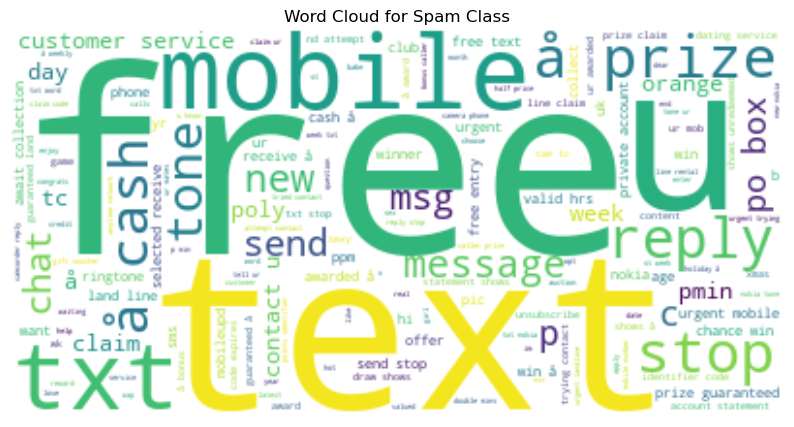

In [12]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = set(ENGLISH_STOP_WORDS)

# Function to preprocess text by removing stopwords
def preprocess_text(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing
df['cleaned_text'] = df['processed_text'].apply(preprocess_text)

# Generate and plot word cloud for each class
def plot_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Separate text by label
ham_text = df[df['label'] == 'ham']['cleaned_text']
spam_text = df[df['label'] == 'spam']['cleaned_text']

# Plot word clouds
plot_wordcloud(ham_text, 'Word Cloud for Ham Class')
plot_wordcloud(spam_text, 'Word Cloud for Spam Class')

# 2. Bag of Words 


In [13]:
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text data to vectors
X = vectorizer.fit_transform(df['cleaned_text'])

# Convert the result to a DataFrame for better readability
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Optionally, you can include the label column for reference
X_df['label'] = df['label'].values

# Display the shape of the vectorized data and a sample of the result
print(f"Shape of the vectorized data: {X_df.shape}")
print(X_df.head())

Shape of the vectorized data: (5572, 8214)
   aa  aah  aaniye  aaooooright  aathilove  aathiwhere  ab  abbey  abdomen  \
0   0    0       0            0          0           0   0      0        0   
1   0    0       0            0          0           0   0      0        0   
2   0    0       0            0          0           0   0      0        0   
3   0    0       0            0          0           0   0      0        0   
4   0    0       0            0          0           0   0      0        0   

   abeg  ...  ìïll  ûthanks  ûªm  ûªt  ûªve  ûï  ûïharry  ûò  ûówell  label  
0     0  ...     0        0    0    0     0   0        0   0       0    ham  
1     0  ...     0        0    0    0     0   0        0   0       0    ham  
2     0  ...     0        0    0    0     0   0        0   0       0   spam  
3     0  ...     0        0    0    0     0   0        0   0       0    ham  
4     0  ...     0        0    0    0     0   0        0   0       0    ham  

[5 rows x 8214 colu

In [14]:
# Separate the vectorized data by class
ham_vectors = X_df[X_df['label'] == 'ham'].drop('label', axis=1)
spam_vectors = X_df[X_df['label'] == 'spam'].drop('label', axis=1)

# Display the shapes of the separated data
print(f"Shape of ham vectors: {ham_vectors.shape}")
print(f"Shape of spam vectors: {spam_vectors.shape}")


Shape of ham vectors: (4825, 8213)
Shape of spam vectors: (747, 8213)


# 3. Ml model and F1 score

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report

# Features and labels
X = X_df.drop('label', axis=1)
y = X_df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the F1-score
f1 = f1_score(y_test, y_pred, pos_label='spam', average='binary')

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the F1-score
print(f"F1-score: {f1:.4f}")


              precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1453
        spam       0.86      0.91      0.89       219

    accuracy                           0.97      1672
   macro avg       0.92      0.95      0.93      1672
weighted avg       0.97      0.97      0.97      1672

F1-score: 0.8869


In [16]:
#The model performs well on the "ham" class with high precision, recall, and F1-score.
#The model performs reasonably well on the "spam" class but with lower precision and recall compared to the "ham" class.

# 4. Tf-IDF vectors F1 score

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the text to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Apply Naive Bayes classifier
nb_classifier_tfidf = MultinomialNB()
nb_classifier_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predict the labels for the test set
y_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf)

# Evaluate the model and record the F1-score
report_tfidf = classification_report(y_test_tfidf, y_pred_tfidf)
print(report_tfidf)

# Extract F1-score from the classification report
from sklearn.metrics import f1_score

f1_tfidf = f1_score(y_test_tfidf, y_pred_tfidf, average='weighted')
print(f"F1-score: {f1_tfidf:.4f}")


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115

F1-score: 0.9668


In [ ]:
#The high F1 score of .9668 indicates a drastic improvement in the model due to the weighted TFID vectorization

# 5. Preprocessing function with IDFtf

In [27]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\S+@\S+', '', text)  # Remove email-ids
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))  # Set of stopwords
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = nltk.WordNetLemmatizer()  # Lemmatizer
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return ' '.join(tokens)  # Join tokens back into a single string

# Apply preprocessing to the text column
df['processed_text'] = df['text'].apply(preprocess_text)

# Convert the preprocessed text to TF-IDF vectors
tfidf_vectorizer_preprocessed = TfidfVectorizer()
X_tfidf_preprocessed = tfidf_vectorizer_preprocessed.fit_transform(df['processed_text'])

# Split the data into training and testing sets
X_train_tfidf_preprocessed, X_test_tfidf_preprocessed, y_train_tfidf_preprocessed, y_test_tfidf_preprocessed = train_test_split(X_tfidf_preprocessed, df['label'], test_size=0.2, random_state=42)

# Apply Naive Bayes classifier
nb_classifier_tfidf_preprocessed = MultinomialNB()
nb_classifier_tfidf_preprocessed.fit(X_train_tfidf_preprocessed, y_train_tfidf_preprocessed)

# Predict the labels for the test set
y_pred_tfidf_preprocessed = nb_classifier_tfidf_preprocessed.predict(X_test_tfidf_preprocessed)

# Evaluate the model and record the F1-score
report_tfidf_preprocessed = classification_report(y_test_tfidf_preprocessed, y_pred_tfidf_preprocessed)
print(report_tfidf_preprocessed)

# Extract F1-score from the classification report
f1_tfidf_preprocessed = f1_score(y_test_tfidf_preprocessed, y_pred_tfidf_preprocessed, average='weighted')
print(f"F1-score (TF-IDF with Preprocessing): {f1_tfidf_preprocessed:.4f}")


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115

F1-score (TF-IDF with Preprocessing): 0.9638


# 6. F1-scores of each method


In [28]:
print(f"F1-score (BoW): {f1_bow:.4f}")
print(f"F1-score (TF-IDF): {f1_tfidf:.4f}")
print(f"F1-score (TF-IDF with Preprocessing): {f1_tfidf_preprocessed:.4f}")


F1-score (BoW): 0.9267
F1-score (TF-IDF): 0.8679
F1-score (TF-IDF with Preprocessing): 0.9638


BoW (Bag of Words): Represents text as a collection of word frequencies, ignoring grammar and word order but considering multiplicity.
TF-IDF (Term Frequency-Inverse Document Frequency): Enhances the BoW model by considering the importance of a word in a document relative to a collection of documents.
TF-IDF with Preprocessing: Further enhances TF-IDF by cleaning the text, removing noise, and normalizing the words, leading to potentially better model performance.